In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import psycopg
import credencials
import warnings

In [90]:
warnings.filterwarnings("ignore")

In [91]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [92]:
week = '2022-10-21'


# Weekly Hospital Report

In [93]:
print("Report Week: " + week)
print("Generated By: Blackbirds")

Report Week: 2022-10-21
Generated By: Blackbirds


In [94]:
# Connect to the sql server
conn = psycopg.connect(
        host="sculptor.stat.cmu.edu", dbname=credencials.DB_USER,
        user=credencials.DB_USER, password=credencials.DB_PASSWORD
)

cur = conn.cursor()

In [95]:
# Check if data is in database
dates = pd.read_sql_query("select \
                            count(distinct date) \
                            from hospital_weekly \
                            where date = %(week)s;"
                            , conn
                            , params={'week':week})


if dates.iloc[0,0] > 0:
    run = True
else:
    run = False
    print("No Hospital Data Found For This Week. Please Try Another Date")


# Hospital Records Loaded Compared to Previous 4 Weeks

In [96]:
if run == True:
    weekly_uploads = pd.read_sql_query("SELECT \
                                            to_char(date, 'Month dd, YYYY'), \
                                            count(hospital_pk) \
                                            from hospital_weekly \
                                            where date between (date (%(week)s) - interval '4 week') and %(week)s \
                                            group by(date) \
                                            order by date;"
                                            , conn
                                            , params={'week':week})

In [97]:
if run == True:
    # Create Table
    def highlight_max(x):
        return ['font-weight: bold' if v == x.loc[x.shape[0]-1] else ''
                    for v in x]

    weekly_uploads = weekly_uploads.rename(columns={"to_char":"Week","count":"Records Loaded"})
    weekly_uploads.style.format({"Records Loaded":"{:,.0f}"}).hide_index().apply(highlight_max)


Week,Records Loaded
"September 23, 2022","4,995"
"September 30, 2022","4,997"
"October 07, 2022","4,996"
"October 14, 2022","4,995"
"October 21, 2022","4,985"


# Bed Breakdown Compared to Previous 4 weeks

In [98]:
if run == True:
    weekly_beds = pd.read_sql_query("select \
                                    to_char(date, 'Month dd, YYYY'), \
                                    sum(coalesce(adult_bed_avail,0)) as Adult_Beds_Avail, \
                                    sum(coalesce(child_bed_avail,0)) as Child_Beds_Avail, \
                                    sum(coalesce(adult_bed_used,0)) as Adult_Beds_Used, \
                                    sum(coalesce(child_bed_used,0)) as Child_Bed_Used, \
                                    sum(coalesce(all_COVID_patient,0)) as All_COVID_Patient \
                                    from hospital_weekly as a \
                                    where date between (date (%(week)s) - interval '4 week') and %(week)s \
                                    group by a.date \
                                    order by a.date; " 
                                    , conn\
                                    , params={'week':week})

    weekly_beds = weekly_beds.rename(columns={"to_char":"Week",
                                                "adult_beds_avail":"Adult Available",
                                                "child_beds_avail":"Child Available",
                                                "adult_beds_used":"Adult Used",
                                                "child_bed_used":"Child Used",
                                                "all_covid_patient":"Covid Patients"})

    weekly_beds.style.format({"Adult Available":"{:,.0f}",
                                "Child Available":"{:,.0f}",
                                "Adult Used":"{:,.0f}",
                                "Child Used":"{:,.0f}",
                                "Covid Patients":"{:,.0f}"}).hide_index().apply(highlight_max)

Week,Adult Available,Child Available,Adult Used,Child Used,Covid Patients
"September 23, 2022","413,560","39,606","34,825","27,778","25,601"
"September 30, 2022","416,279","39,805","34,852","28,043","24,142"
"October 07, 2022","415,465","39,797","34,886","28,286","23,689"
"October 14, 2022","412,939","39,712","34,841","28,799","23,696"
"October 21, 2022","414,880","39,882","34,376","29,706","24,117"


# Number of Beds Used By Quality Rating For Most Recent Week

In [100]:
if run == True:
    quality_beds = pd.read_sql_query("select \
                                        b.quality, \
                                         sum(coalesce(a.adult_bed_used,0)) \
                                            + sum(coalesce(a.child_bed_used,0)) as beds_used \
                                        , sum(coalesce(a.adult_bed_avail,0)) \
                                            + sum(coalesce(a.child_bed_avail,0)) as beds_avail \
                                        , (sum(coalesce(a.adult_bed_used,0)) \
                                            + sum(coalesce(a.child_bed_used,0))) \
                                            / (sum(coalesce(a.adult_bed_used,0)) \
                                            + sum(coalesce(a.child_bed_used,0)) \
                                            + sum(coalesce(a.adult_bed_avail,0)) \
                                            + sum(coalesce(a.child_bed_avail,0))) as percent_bed \
                                        from hospital_weekly as a \
                                        inner join ( \
                                            select \
                                                b.hospital_pk, \
                                                b.quality \
                                                    from ( \
                                                        select \
                                                            a.*, \
                                                            (rank() OVER (PARTITION BY hospital_pk ORDER BY date desc)) as rank \
                                                        from hospital_quality as a \
                                                        where date <= %(week)s and quality is not null) as b \
                                                where rank = 1) b \
                                            ON a.hospital_pk = b.hospital_pk and a.date = %(week)s \
                                        group by b.quality \
                                        order by b.quality;"
                                        , conn
                                        , params={'week':week})

    quality_beds = quality_beds.rename(columns={"quality":"Quality",
                                                "beds_used":"Beds Used",
                                                "beds_avail":"Beds Not Used",
                                                "percent_bed":"Percentage of Beds Used"})
    # Table Format
    quality_beds.style.format({"Quality":"{:,.0f}",
                                "Beds Used":"{:,.0f}",
                                "Beds Not Used":"{:,.0f}",
                                "Percentage of Beds Used":"{:,.2%}"}).hide_index().apply(highlight_max)

Quality,Beds Used,Beds Not Used,Percentage of Beds Used
1,"2,987","37,884",7.31%
2,"9,367","101,006",8.49%
3,"11,196","118,893",8.61%
4,"11,433","102,324",10.05%
5,"4,547","44,222",9.32%


# All Time Comparison of Beds Used vs COVID Cases

In [80]:
if run == True:
        alltime_beds = pd.read_sql_query("select \
                                                to_char(date, 'Month dd, YYYY'), \
                                                sum(coalesce(adult_bed_used,0)) \
                                                        + sum(coalesce(child_bed_used,0)) as All, \
                                                sum(coalesce(all_COVID_patient,0)) as COVID\
                                        from hospital_weekly \
                                        where date <= %(week)s \
                                        group by date \
                                        order by date;" \
                                        , conn
                                        , params={'week':week})

        alltime_beds = alltime_beds.rename(columns={"to_char":"Week",
                                                "all":"All Cases",
                                                "covid":"Covid Cases"})
        # Table Format
        alltime_beds.style.format({"All Cases":"{:,.0f}",
                                "Covid Cases":"{:,.0f}"}).hide_index().apply(highlight_max)

Week,All Cases,Covid Cases
"September 23, 2022","62,603","25,601"
"September 30, 2022","62,895","24,142"
"October 07, 2022","63,172","23,689"
"October 14, 2022","63,640","23,696"
"October 21, 2022","64,082","24,117"


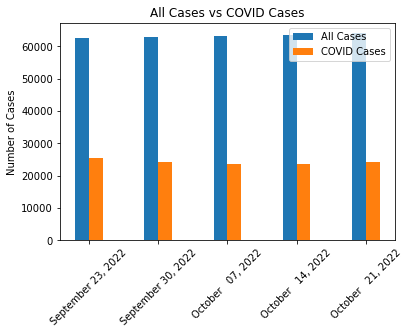

In [81]:
if run == True:
    x_axis = np.arange(len(alltime_beds["Week"]))
    p = plt.bar(x_axis - 0.1, alltime_beds["All Cases"], 0.2, label = "All Cases")
    p = plt.bar(x_axis + 0.1, alltime_beds["Covid Cases"], 0.2, label = "COVID Cases")
    p = plt.xticks(x_axis, alltime_beds["Week"], rotation = 45)
    p = plt.title("All Cases vs COVID Cases")
    p = plt.ylabel("Number of Cases")
    p = plt.legend(loc = 'upper right')
    plt.show()

# Chart of COVID Cases by State

In [82]:
if run == True:
    covid_map = pd.read_sql_query("select \
                                    state, \
                                    sum(coalesce(all_COVID_patient,0)) as covid_sum \
                                    from hospital_weekly as a \
                                    full outer join hospital as b \
                                    on a.hospital_pk = b.hospital_pk \
                                    where date = %(week)s \
                                    group by b.state;"
                                    , conn
                                    , params={'week':week})

    covid_map = covid_map.rename(columns={"covid_sum":"COVID Cases"})


In [83]:
if run == True:
    fig = px.choropleth(covid_map,
                        locations='state', 
                        locationmode="USA-states", 
                        scope="usa",
                        color='COVID Cases',
                        color_continuous_scale="Viridis_r"
                        )

    fig.show()

# US States with the Largest COVID Increase Compared to Previous Week

In [84]:
if run == True:
   covid_state = pd.read_sql_query("select \
                                       a.state, \
                                       (a.covid_current - b.covid_prev) as COVID_Increase \
                                       from ( \
                                          select \
                                          state, \
                                          sum(coalesce(all_COVID_patient,0)) as covid_current \
                                          from hospital_weekly as a \
                                          full outer join hospital as b \
                                          on a.hospital_pk = b.hospital_pk \
                                          where date = %(week)s \
                                          group by b.state) a \
                                          inner join ( \
                                             select \
                                             state, \
                                             sum(coalesce(all_COVID_patient,0)) as covid_prev \
                                             from hospital_weekly as a \
                                             full outer join hospital as b \
                                             on a.hospital_pk = b.hospital_pk \
                                             where date = date (%(week)s) - interval '1 week' group by b.state) b \
                                          on a.state = b.state \
                                          order by (a.covid_current - b.covid_prev) DESC\
                                          limit 10;" \
                                          , conn
                                          , params={'week':week})

   covid_state = covid_state.rename(columns={"state":"State",
                                             "covid_increase":"Case Increase"})
   # Table Format
   covid_state.style.format({"Case Increase":"{:,.0f}"}).hide_index()

State,Case Increase
IL,133
WI,81
OH,80
IN,68
MN,66
AZ,64
PA,60
MO,50
NY,43
NJ,40


# Hospitals with the Largest Increase in COVID Cases Compared to Previous Week

In [85]:
if run == True:
   covid_hosp = pd.read_sql_query("select \
                                    a.hospital_name, \
                                    a.city, \
                                    a.state, \
                                    (a.covid_current - b.covid_prev) as COVID_Increase \
                                    from ( \
                                          select \
                                             b.hospital_name, \
                                             a.hospital_pk, \
                                             b.city, \
                                             b.state, \
                                             sum(coalesce(all_COVID_patient,0)) as covid_current \
                                             from hospital_weekly as a \
                                             full outer join hospital as b \
                                                on a.hospital_pk = b.hospital_pk \
                                             where date = %(week)s \
                                             group by a.hospital_pk, b.hospital_name, b.city, b.state) a \
                                          inner join ( \
                                             select \
                                                b.hospital_name, \
                                                a.hospital_pk, \
                                                b.city, \
                                                b.state, \
                                                sum(coalesce(all_COVID_patient,0)) as covid_prev \
                                             from hospital_weekly as a \
                                             full outer join hospital as b on a.hospital_pk = b.hospital_pk \
                                             where date = date (%(week)s) - interval '1 week' \
                                             group by a.hospital_pk, b.hospital_name, b.city, b.state) b \
                                       on a.hospital_pk = b.hospital_pk \
                                       order by (a.covid_current - b.covid_prev) DESC\
                                       limit 10;" \
                                       , conn
                                       , params={'week':week})

   covid_hosp = covid_hosp.rename(columns={"hospital_name":"Hospital Name",
                                             "city":"City",
                                             "state":"State",
                                             "covid_increase":"Case Increase"})
   # Table Format
   covid_hosp.style.format({"Case Increase":"{:,.0f}"}).hide_index()

Hospital Name,City,State,Case Increase
CAROLINAS MEDICAL CENTER/BEHAV HEALTH,CHARLOTTE,NC,29
NEW YORK-PRESBYTERIAN HOSPITAL,NEW YORK,NY,25
GEISINGER MEDICAL CENTER,DANVILLE,PA,18
HOUSTON METHODIST HOSPITAL,HOUSTON,TX,16
MAINE MEDICAL CENTER,PORTLAND,ME,16
MIAMI VALLEY HOSPITAL,DAYTON,OH,14
VALLEYWISE HEALTH MEDICAL CENTER,PHOENIX,AZ,14
CAPE CORAL HOSPITAL,CAPE CORAL,FL,13
MOUNT SINAI WEST,NEW YORK,NY,12
WELLSTAR PAULDING HOSPITAL,HIRAM,GA,12


In [86]:
conn.close()